# Natural Language Processing using RNN and Transformer, Part 1

Alan Turing was a pioneering British mathematician, logician and computer scientist who made significant contributions to the fields of mathematics, logic, cryptography and early computer science. One of his most famous concepts is the **"Turing Test"**.

He proposed the Turing Test in his paper "Computing Machinery and Intelligence", published in 1950. The paper addressed the question: "Can machines think?"  
Alan Turing had several approaches available for his test: playing chess, recognizing dogs in pictures or generating music. However, it's interesting that he opted for a linguistic approach.  

The Turing Test is a benchmark for evaluating the intelligence of artificial intelligence (AI) or machine learning systems. Turing's idea was to design a test that could determine if a machine could exhibit behavior indistinguishable from that of a human.  
In the Turing Test, a human evaluator interacts with two entities through a computer terminal — one is a human and the other is a machine. The evaluator communicates with both entities through text-based communication (chatbot). If the evaluator cannot reliably distinguish the machine from the human based on the responses received, the machine is said to have passed the Turing Test.  
  
Today, the conventional approach for linguistic tasks involves the use of **Recurrent Neural Networks (RNNs)**. RNNs have been instrumental in tackling various natural language processing (NLP) tasks, such as text generation, sentiment analysis and machine translation. Their architecture allows for sequential processing, which is particularly well-suited to language, where the order of words significantly impacts meaning. By processing input step by step, RNNs retain a "memory" of previous elements, enabling them to generate coherent and contextually relevant text sequences. This makes RNNs, along with related architectures like Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU), crucial in advancing machine capabilities in conversational AI, enabling machines to generate human-like responses that can pass or approach the standards set by the Turing Test.
  
However, in recent years, the dominance of **Transformers** has shifted the landscape of NLP. Unlike RNNs, which rely on sequential data processing, Transformers use self-attention mechanisms to capture relationships between words regardless of their distance from one another in the input. This parallel processing capability makes them highly efficient, particularly for tasks involving long-range dependencies in text. As a result, Transformers have revolutionized the field, outperforming RNNs on a wide array of tasks, from machine translation to text summarization, question answering and beyond. The scalability and effectiveness of Transformers have led to breakthroughs in conversational AI, where machines now exhibit a deeper understanding of context, nuance and even elements of creativity in language generation.

In this project, we examine the 'emotions' dataset, which comprises 416.809 text segments extracted from Twitter (now called "X") messages. Each segment is paired with a label that identifies the predominant emotion conveyed.  
The dataset categorizes emotions into six classes: 
- sadness (0)
- joy (1)
- love (2) 
- anger (3)
- fear (4)
- surprise (5)  

We will explore both a RNN and a Transformer by training models from both architectures on the same linguistic tasks:  
We will prepare the Twitter texts for **sentiment analysis** using Byte Pair Encoding (BPE). The data will be split into training, validation and test sets. The RNN will feature bidirectional layers. The architecture of the transformer model will mostly follow the standard configuration for an encoder-only transformer.  

**Note:**  
Since using Optuna for hyperparameter optimization for both models within the same notebook is computationally intensive, the transformer model will be trained in a separate notebook titled 'Natural Language Processing using RNN and Transformer, Part 2.' This approach helps to reduce the computational load and allows for a more efficient optimization process by focusing on one model at a time.

## Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

### Custom Functions

In [2]:
# matplotlib settings
mpl.rc("lines", linewidth = 2.)
mpl.rc("axes", facecolor = ".9", edgecolor = "k")
mpl.rc("xtick", color = "k")
mpl.rc("ytick", color = "k")
mpl.rc("text", color = "k")
mpl.rc("figure", facecolor = "w", edgecolor = "k")

# Function for an initial inspection of the data
def get_data_info(dataframe):
    '''
    function to get most important info about DataFrame
    '''
    print("\nBASIC INFO\n")
    print(dataframe.info())
    print("=" * 100)
    print("DATAFRAME SHAPE\n", dataframe.shape)
    print("=" * 100)
    print("NUMBER OF DUPLICATE ROWS\n", dataframe.duplicated().sum())
    print("=" * 100)
    print("NULL VALUES")
    print(dataframe.isnull().sum())
    print("=" * 100)

We are downloading the dataset 'emotions.csv' from kaggle.com and take a first look at it.


In [3]:
df_start = pd.read_csv('/kaggle/input/emotions/text.csv') 
df_start.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


The data contains three features: 'Unnamed: 0', 'text' and 'label'. 'Unnamed: 0' is merely an index and can be disregarded by us. 'text' contains the tweets and 'label' assigns the corresponding emotion to the tweets.

In [4]:
get_data_info(df_start)


BASIC INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB
None
DATAFRAME SHAPE
 (416809, 3)
NUMBER OF DUPLICATE ROWS
 0
NULL VALUES
Unnamed: 0    0
text          0
label         0
dtype: int64


We can see that the dataset contains no missing values and no duplicate rows. Nevertheless, we will remove the column 'Unnamed: 0' as it does not provide useful information.

In [5]:
df_start.drop('Unnamed: 0', axis=1, inplace=True)

We will proceed with a copy of 'df_start' from now on.

In [6]:
df=df_start
df.shape

(416809, 2)

## Data Preparation

Proper data preparation is crucial to ensure the effectiveness and accuracy of machine learning models, especially in natural language processing tasks.
  
**Text Processing:**  
Initially, the raw text data undergoes a preprocessing phase. This involves cleaning the data by removing unwanted elements such as HTML tags, URLs, punctuation and stopwords. Additionally, tokenization and lemmatization are applied to ensure consistency and reduce the words to their base forms.  
**Word Cloud Analysis:**  
To gain an understanding of the most frequent terms within the dataset, a word cloud is generated. This visual representation helps identify common words and potential patterns in the data.  
**Data Distribution:**  
Analyzing the distribution of text data helps ensure there is no imbalance. This step helps avoid biases that could affect the model's performance.  
**Data Splitting:**  
The dataset is then split into training, validation and test sets. The training set is used to teach the model, the validation set helps in tuning hyperparameters and the test set serves as the final evaluation for the model’s performance.  
**Byte-Pair Encoding (BPE):**  
To handle vocabulary efficiently and represent the text in a model-friendly format, byte-pair encoding is applied. BPE breaks down words into subword units, which helps in dealing with rare or unknown words effectively.
  
Each of these steps is essential for preparing the data in a way that maximizes the performance and generalization capabilities of the models that will be trained.

In [7]:
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers
from collections import Counter

2024-10-10 12:44:44.609296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 12:44:44.609397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 12:44:44.865933: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Text Preprocessing

Preparing text data is a crucial step for any model, especially in the context of sentiment analysis. The function preprocess_text is defined to streamline this process and ensure the input is suitable for further analysis.
  
In this function, the first step is to check if the input is a string. If not, it raises a ValueError, ensuring the function operates on the correct data type. This is important for maintaining robustness and preventing runtime errors during model training or inference.   
Next, the text is converted to lowercase. This standardization helps reduce variations that do not carry semantic meaning, allowing the model to treat "Happy" and "happy" as the same term.  
HTML tags and URLs are then removed from the text. These elements often do not contribute valuable information for sentiment analysis and can add noise to the dataset, potentially misleading the model. By eliminating these distractions, we can focus on the core sentiment expressed in the text.  
All punctuation is also removed, simplifying the text and enabling cleaner tokenization later on.  
  
Unlike approaches that might remove specific tokens or words, this simplified function retains all words, which is beneficial because:  
By not removing any specific words or tokens, we maintain the original context and sentiment, which is crucial for sentiment analysis. Every word in the input could carry sentiment information that may impact the outcome.  
Since Byte Pair Encoding (BPE) will be applied after this preprocessing, it's advantageous to keep the words intact. BPE operates by splitting words into subwords or tokens based on frequency and by retaining the original words, we allow BPE to create the most meaningful subword units. This can help manage vocabulary size effectively and improve the model's handling of new or rare words.  
Avoiding complex transformations such as lemmatization keeps the preprocessing straightforward. While lemmatization can be helpful in certain contexts, it may not be necessary when using BPE. BPE can adequately handle word variations and morphology, making lemmatization redundant for this specific pipeline.
  
In summary, the preprocess_text function serves to clean and prepare the input text effectively, ensuring that it is standardized and free of unnecessary elements, while preserving all relevant words for subsequent processing with BPE.

In [8]:
def preprocess_text(text):
    if not isinstance(text, str):
        raise ValueError("Input must be a string")
    
    # Convert the text to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove all punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [9]:
df['text_prepro'] = df['text'].apply(preprocess_text)
df.head()

,text,label,text_prepro
0,i just feel really helpless and heavy hearted,4,i just feel really helpless and heavy hearted
1,ive enjoyed being able to slouch about relax a...,0,ive enjoyed being able to slouch about relax a...
2,i gave up my internship with the dmrg and am f...,4,i gave up my internship with the dmrg and am f...
3,i dont know i feel so lost,0,i dont know i feel so lost
4,i am a kindergarten teacher and i am thoroughl...,4,i am a kindergarten teacher and i am thoroughl...


We will no longer use the original text and can therefore drop the 'text' column.

In [10]:
df.drop('text', axis=1, inplace=True)
df.shape

(416809, 2)

### WordCloud

A WordCloud is a visualization technique used to depict the most frequent words in a corpus of text data. It provides an intuitive and visually appealing way to showcase the most significant words associated with different sentiments. This allows quick identification of dominant themes or emotions expressed in the text.

In [11]:
# Dictionary mapping labels to emotions
label_dict = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

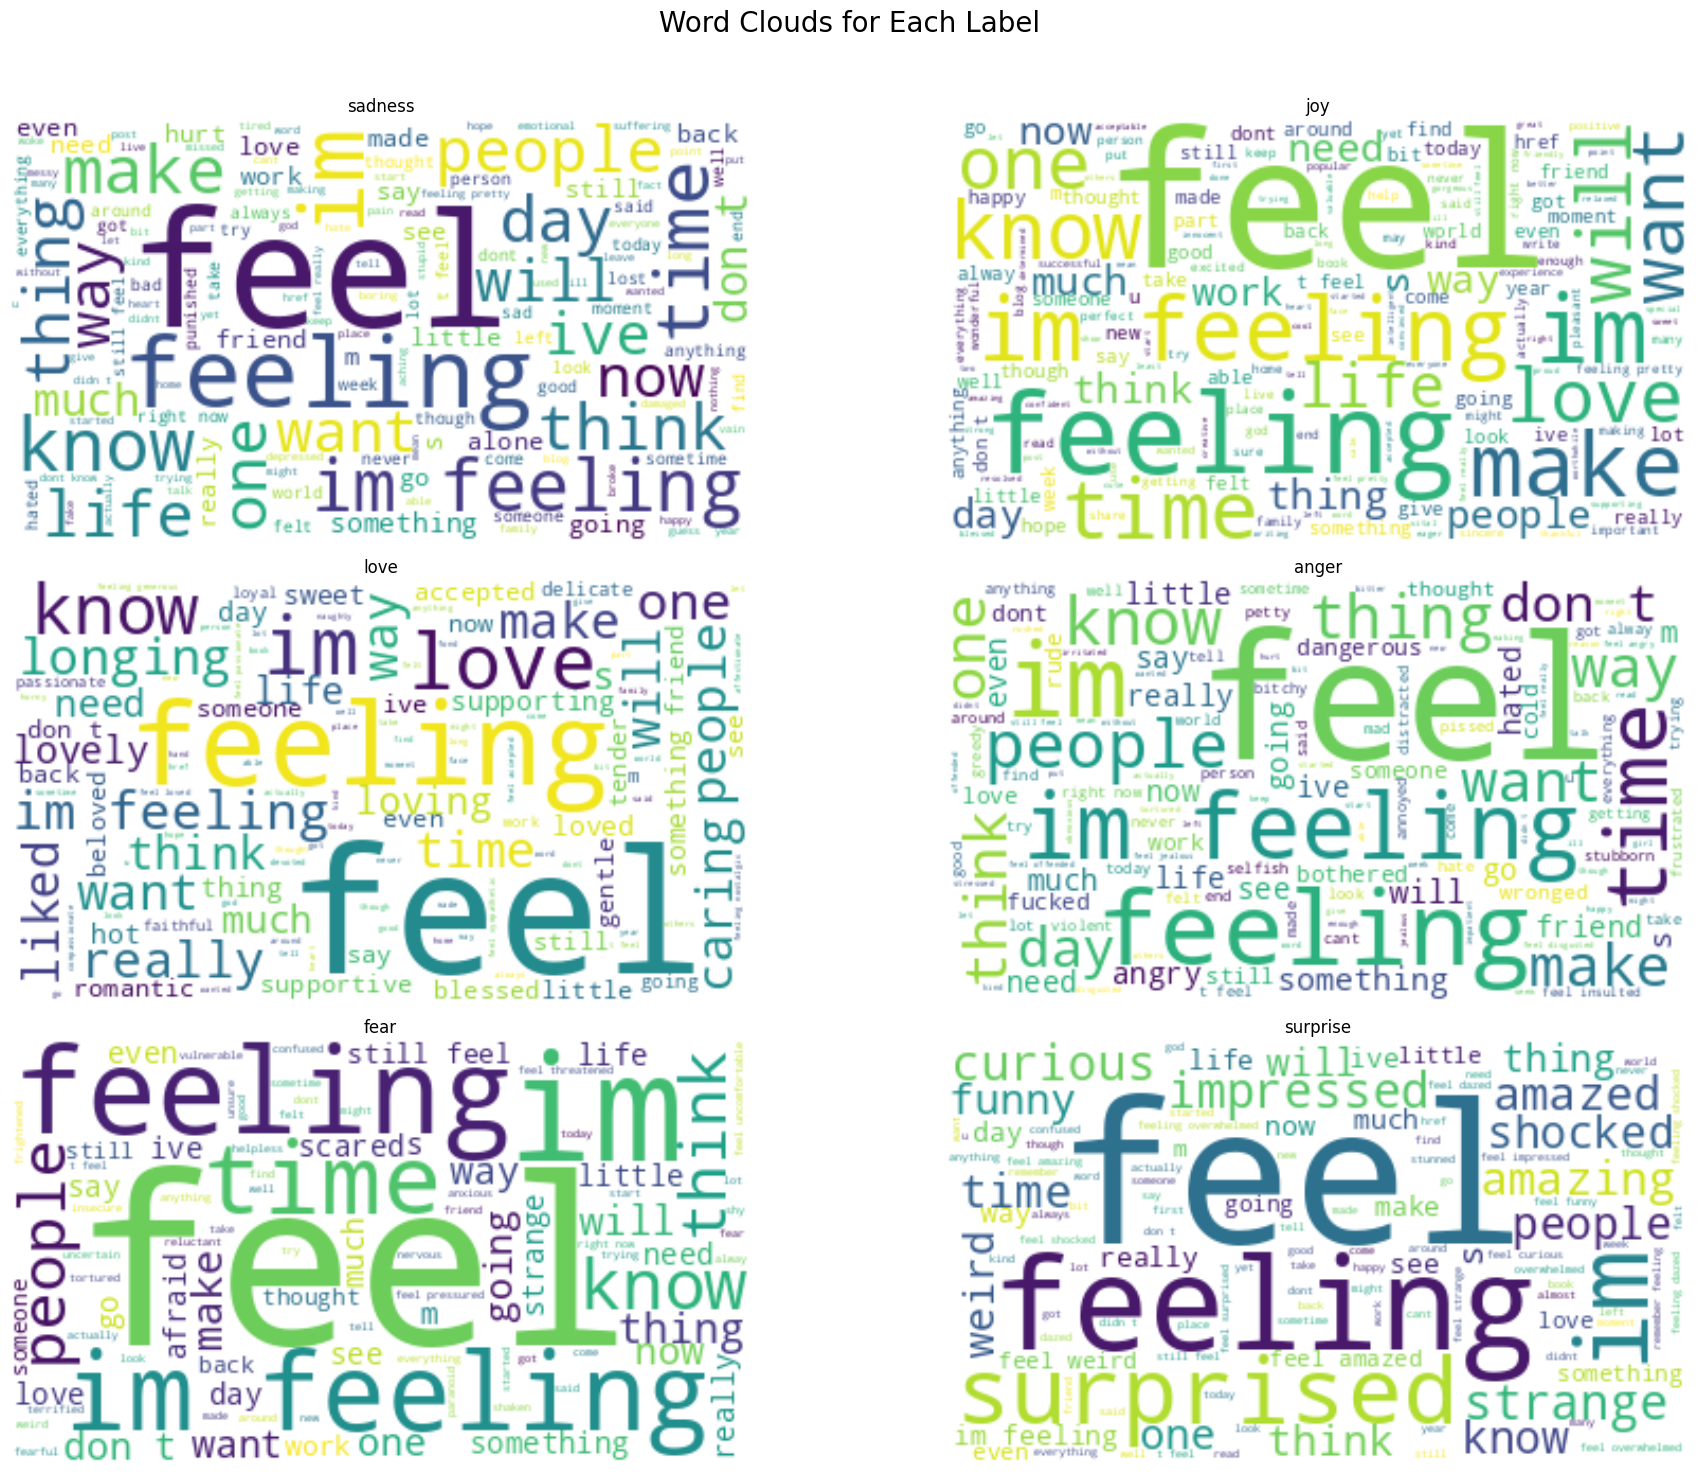

In [12]:
def create_wordcloud(text, title):
    # Create a WordCloud object
    wordcloud = WordCloud(width=350, height=200, background_color='white').generate(text)
    
    # Display the WordCloud image with bilinear interpolation
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  
    plt.title(title)  

# Group text by label and concatenate into a single text per label
grouped_text = df.groupby('label')['text_prepro'].apply(' '.join).reset_index()

# Create subplots for each label's WordCloud
fig, axes = plt.subplots(3, 2, figsize=(20, 15))  
fig.suptitle('Word Clouds for Each Label', fontsize=20)  

# Plot WordClouds for each label
for i in range(6):
    if i in grouped_text['label'].values:
        # Get text for the current label
        text = grouped_text[grouped_text['label'] == i]['text_prepro'].values[0]
        ax = axes[i // 2, i % 2]  # Select subplot position
        plt.sca(ax)  
        create_wordcloud(text, label_dict[i])  # Create WordCloud for the current label
    else:
        print(f"Label '{label_dict[i]}' not found in the DataFrame.")

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

For all emotions, the word 'feel' appears most frequently. However, we also observe differences:

- 'love' and 'support' are significant for the 'love' label.
- 'hate' and 'want' appear to be associated with the 'anger' label.
- 'amaz' ('amazing') and 'shock' are predominant for the 'surprise' label.

### Data Distribution

We want to examine the distribution of the classes (the labels).  
Let's check if there is a significant imbalance in the distribution of sentiment classes. Imbalance can affect the model's ability to generalize well, particularly if one class is underrepresented compared to others.

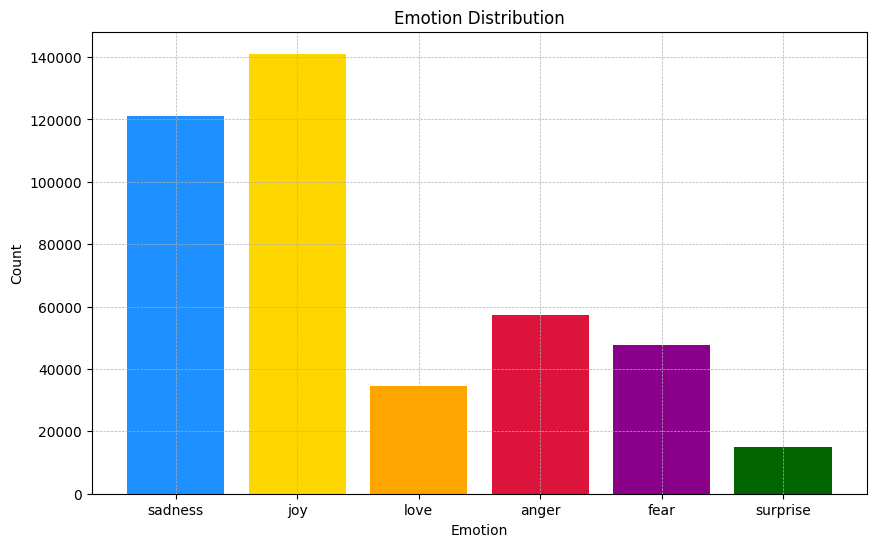

In [13]:
# Counting the frequency of each label
label_counts = df['label'].value_counts().sort_index()

# Converting numerical labels to word labels
labels = [label_dict[i] for i in label_counts.index]
counts = label_counts.values

# Colors for the bars
colors = ['#1E90FF', '#FFD700', '#FFA500', '#DC143C', '#8B008B', '#006400']

# Creating the Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=colors)  
plt.xlabel('Emotion') 
plt.ylabel('Count') 
plt.title('Emotion Distribution')  
plt.grid(True, linestyle='--', linewidth=0.5)  
plt.gca().set_facecolor('white')  

plt.gcf().set_facecolor('white')

plt.show() 

The dataset is highly imbalanced.  
An imbalanced dataset can significantly affect the performance of a machine learning model. When the dataset is imbalanced, it means that some classes (here: 'sadness' and 'joy') are represented by far more examples than others. As a result, the model tends to become biased towards the more frequent classes. For instance, if one class dominates the dataset, the model might learn to predict this class more often, even when the input data suggests otherwise. This can lead to poor performance on the underrepresented classes as the model hasn't had learned their characteristics effectively. Consequently, the overall accuracy might be misleadingly high, as the model performs well on the dominant classes but fails to generalize across all classes. In practical applications, this can result in unreliable predictions. Therefore, addressing imbalance is essential to ensure that the model accurately captures the full range of sentiments in the data.  
  
We will address this topic in the following chapters. Additionally, we will not focus solely on the overall accuracy of the model but will instead concentrate on the model's precision for each individual class during the evaluation.

### Splitting the Data and Byte Pair Encoding (BPE)

We will split the data.  
This approach ensures that the model is trained on a large portion of the data (train_texts, train_labels), validated on a separate subset (valid_texts, valid_labels) and finally tested on an unseen subset (test_texts, test_labels). This separation helps evaluate the model's performance and generalization ability.  
  
But first, we will determine the maximum of the text lengths which we will need for the Byte Pair Encoding.

In [14]:
df['text_length']=df['text_prepro'].apply(lambda x: len(x.split()))

max_length = df['text_length'].max()

print('Maximum of feature text_length in dataframe df is:', max_length)

Maximum of feature text_length in dataframe df is: 178


Now we will split the data:

In [15]:
# Split the data into training and validation sets
train_texts, valid_texts, train_labels, valid_labels = train_test_split(df['text_prepro'], df['label'], test_size=0.2, random_state=42)

# Split the validation data into validation and test data
valid_texts, test_texts, valid_labels, test_labels = train_test_split(valid_texts, valid_labels, test_size=0.5, random_state=42)

**Byte Pair Encoding (BPE)** is a tokenization algorithm that is particularly effective in handling subword units. BPE merges the most frequent pair of characters or character sequences into a single token, progressively building up a vocabulary of common subwords.

BPE is particularly useful for sentiment analysis for several reasons. First, it can handle out-of-vocabulary words more effectively than traditional word-level tokenization methods. By breaking down rare or unseen words into subwords or even individual characters, BPE ensures that the model can still understand and process them. This is especially important in social media text, where spelling variations, abbreviations and slang are common.  
Second, BPE strikes a balance between word-level and character-level representations, combining the strengths of both. It captures the morphological structure of words by identifying meaningful subwords, which can be particularly beneficial for understanding sentiment. For instance, the subwords "un-" and "happy" in "unhappy" convey important sentiment information that might be lost with simple word tokenization.  
  
The number of unique tokens is used as the base vocabulary size. Since BPE can split rare or unknown words into subword units, the vocabulary size is increased to leave room for these subwords. This ensures the tokenizer can efficiently represent most of the data while also being flexible enough to handle rare or unknown terms.

In [16]:
# Function to calculate token frequencies
def calculate_token_frequencies(texts, tokenizer):
    token_counts = Counter()
    for text in texts:
        tokens = tokenizer.pre_tokenizer.pre_tokenize_str(text)
        for token in tokens:
            token_counts[token[0]] += 1
    return token_counts

# Tokenizer setup for Byte Pair Encoding (BPE)
bpe_tokenizer = Tokenizer(models.BPE())
bpe_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
bpe_tokenizer.decoder = decoders.BPEDecoder()

# Calculate token frequencies in the training dataset
token_counts = calculate_token_frequencies(train_texts, bpe_tokenizer)

# Add 20% buffer to number of tokens
vocab_size = int(len(token_counts) * 1.2)

print(f"Vocab Size: {vocab_size}")

# Train the BPE tokenizer with the determined vocab size
trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=["<pad>", "<unk>"])
bpe_tokenizer.train_from_iterator(train_texts, trainer)

# Function to encode texts with the BPE tokenizer
def bpe_encode(texts, tokenizer, max_length):
    encodings = [tokenizer.encode(text).ids for text in texts]
    padded_encodings = tf.keras.preprocessing.sequence.pad_sequences(encodings, maxlen=max_length, padding='post')
    return padded_encodings

# Encode the texts
train_encodings = bpe_encode(train_texts, bpe_tokenizer, max_length)
valid_encodings = bpe_encode(valid_texts, bpe_tokenizer, max_length)
test_encodings = bpe_encode(test_texts, bpe_tokenizer, max_length)

Vocab Size: 4633





We use to_categorical on all the labels.

In [17]:
train_labels = tf.keras.utils.to_categorical(train_labels)
valid_labels = tf.keras.utils.to_categorical(valid_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

# Model Definition: Recurrent Neural Network (RNN)

The following code implements and optimizes a **Recurrent Neural Network (RNN)** model using TensorFlow and **Optuna**, a hyperparameter optimization framework.  
  
To ensure the reproducibility of results, a global random seed is set across TensorFlow, NumPy and Python’s random module. Reproducibility is crucial for consistent experimentation, as it ensures that results can be replicated.
  
The Optuna objective function is defined to construct an RNN model with the hyperparameters suggested by Optuna. These hyperparameters include:  
**Embedding Size (embed_size):**  
The number of dimensions in which words are embedded before being passed into the RNN. Larger embedding sizes can capture more complex word relationships but may increase computational cost.  
  
**LSTM Units (lstm_units):**  
The number of units in the LSTM layer. This controls the capacity of the model to remember sequences. The value of lstm_units is constrained to be less than or equal to the embed_size, ensuring compatibility between layers.  
  
**Dropout Rates (dropout_lstm, dropout_1, dropout_2):**  
Dropout is used for regularization to prevent overfitting by randomly setting some neurons to zero during training. These dropout rates are tuned separately for each layer.  
  
**Dense Layer Units (dense_units_1, dense_units_2):**  
These control the number of neurons in the fully connected layers that come after the LSTM layer. These units are progressively reduced to compress the information extracted by the RNN before outputting the final predictions.  
  
**L2 Regularization (l2_regularizer_1, l2_regularizer_2):**  
L2 regularization is applied to the dense layers to further prevent overfitting by penalizing large weights in the model.  
  
**Learning Rate (initial_learning_rate):**  
The starting learning rate for the Adam optimizer, which uses an exponential decay schedule to reduce the learning rate as training progresses. This ensures the model learns quickly in the early stages and fine-tunes more gradually later.  
  
**Batch Size (batch_size):**  
The number of samples processed in one forward/backward pass. Larger batch sizes offer more stable gradient updates, while smaller ones introduce more noise and variability, possibly improving generalization.  
  
**Architecture of the model:**  
- Embedding Layer:  
Converts the input text into dense vectors of fixed size, as determined by the embed_size hyperparameter.  
- Bidirectional LSTM Layer:  
This layer reads the input sequence both forward and backward, allowing the model to capture contextual information from both directions. For sentiment analysis, this is crucial because the meaning of a word often depends on what comes before and after it.  
Importantly, the LSTM is configured with **return_sequences=False**, which means that instead of outputting a sequence of hidden states for every token, it only outputs the final hidden state. This setting is appropriate because the task is tweet-level emotion classification: the model should produce a single representation that summarizes the entire sequence, not token-level predictions. The final hidden state effectively acts as a condensed representation of the whole input tweet, combining contextual information from both directions.  
- Fully Connected Layers:  
Two dense layers follow the LSTM layer, each with progressively fewer units. The dense layers are regularized using L2 regularization and have dropout applied to prevent overfitting.  
- Output Layer:  
A softmax layer is used for multi-class classification, outputting probabilities for each of the six possible emotion classes. 

In [18]:
pip install optuna-integration

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 4.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [19]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Input, Masking
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import optuna
from optuna_integration.tfkeras import TFKerasPruningCallback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

# Set the global seed
seed = 42

# Control randomness in TensorFlow
tf.random.set_seed(seed)

# Control randomness in NumPy
np.random.seed(seed)


Because the data is imbalanced we use **class_weight** during training. This helps adjust the model to give more importance to underrepresented classes in the data. This adjustment means that the model incurs higher penalties for misclassifying examples from rare classes, preventing it from focusing solely on frequent classes and ignoring the rarer ones. As a result, the model becomes better at predicting these less common classes. While this may lead to a slight decrease in overall accuracy, the performance on rare classes is likely to improve. Additionally, the model faces stronger penalties for misclassifying rare classes, which drives its weights in a more robust direction, potentially leading to better generalization. This approach helps prevent the model from settling on trivial solutions, such as always predicting the majority classes and encourages it to recognize more complex patterns in the data.

In [20]:
# Convert train_lables back to integer-coded labels
train_labels_int = np.argmax(train_labels, axis=1)

# Compute class weights based on the integer-coded labels
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_labels_int), 
    y=train_labels_int
)
class_weight_dict = dict(enumerate(class_weights))

print(class_weight_dict)

{0: 0.5730156929866166, 1: 0.4922322701788261, 2: 2.0117466063348415, 3: 1.2114068358182928, 4: 1.4579594942022143, 5: 4.654870592176899}


To tune the hyperparameters, we use the optimization framework **Optuna**. With Optuna, we optimize the number of LSTM units, the learning rate, the dropout rates, the embedding size and the batch size.

For this, we define an objective function that constructs the RNN model according to the hyperparameters suggested by Optuna during the optimization process. The optimization algorithm systematically explores different combinations of hyperparameters to identify the best configuration for the model. Unlike traditional grid search or random search methods, Optuna efficiently navigates the hyperparameter space, potentially yielding better results with fewer trials.

Firstly, Optuna conducts a hyperparameter search to find the best configuration for the model. It uses a sophisticated sampling strategy that can include techniques like Bayesian optimization, which adjusts the search based on prior results, focusing on the most promising regions of the hyperparameter space. During this process, Optuna's pruning feature can halt unpromising trials early, saving computational resources.

During model compilation, we use categorical_crossentropy as the loss function, which is suitable for multi-class classification tasks, along with the Adam optimizer. We also utilize learning rate schedules during model training to accelerate convergence towards a good solution more effectively than with a constant learning rate.  
  
**Note:**  
In this code, the hyperparameter search space has been restricted compared to an earlier, larger space. Initially, a broader hyperparameter space was used to allow Optuna to explore more diverse configurations. However, since Optuna's optimization process is computationally intensive, and given the limited available resources, the search space was progressively narrowed down to a more manageable size. This restriction helps reduce the computational burden while still focusing on tuning the most critical parameters. It strikes a balance between optimizing model performance and conserving resources.  
  
In general, it is not common practice to define the **Optuna objective function** as a combination of validation loss and validation accuracy, because these metrics are on very different scales and measure different aspects of model performance. However, in this case it was feasible because the hyperparameter search space was already constrained to reasonable values. With these constraints, the validation loss consistently dropped below 1.0 within the first few epochs, which ensured that both metrics stayed in a comparable range. Under these conditions, combining them into a single objective was acceptable for guiding the optimization:  
Our objective function is a **linear combination of the validation loss and validation accuracy**:  
Lower loss values indicate better predictions and higher accuracy indicates better performance.  
So the final objective is a weighted sum where we are minimizing the loss but also penalizing poor accuracy.  
Using both loss and accuracy ensures that the model doesn't just focus on one metric. If we only optimized for accuracy, the model could make trivial decisions (predicting the most frequent class) and still achieve high accuracy without learning useful patterns.
Loss is a finer-grained measure that can still decrease even when accuracy doesn't improve, helping the model learn better representations. Accuracy, on the other hand, gives a more intuitive understanding of model performance.
By assigning weights to loss and accuracy (1.0 for loss and 0.5 for accuracy), we maintain more control over the model's learning process: We emphasize minimizing the loss but still reward the model for improving accuracy.  
This approach combines two objectives into a single objective.

In [21]:
def rnn_objective(trial):

    # Define hyperparameters with constraints
    embed_size = trial.suggest_categorical('embed_size', [80, 96])

    # lstm_units should be <= embed_size
    lstm_units = trial.suggest_int('lstm_units', 80, embed_size, step=16)
    dropout_lstm = trial.suggest_float('dropout_lstm', 0.1, 0.2, step=0.1)
    
    # dense_units_1 should be <= lstm_units_1
    dense_units_1 = trial.suggest_int('dense_units_1', 48, lstm_units, step=16)
    l2_regularizer_1 = trial.suggest_float('l2_regularizer_1', 1e-10, 1e-9, log=True)
    dropout_1 = trial.suggest_float('dropout_1', 0.1, 0.2, step=0.1)
    
     # dense_units_2 should be <= dense_units_1
    dense_units_2 = trial.suggest_int('dense_units_2', 32, dense_units_1, step=16)
    l2_regularizer_2 = trial.suggest_float('l2_regularizer_2', 1e-10, 1e-9, log=True)
    dropout_2 = trial.suggest_float('dropout_2', 0.2, 0.2, step=0.1)
    
    initial_learning_rate = trial.suggest_float('initial_learning_rate', 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])

    # Build the model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(max_length,), name="Input_Layer"))
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, mask_zero=True, name="Embedding_Layer"))
    model.add(Masking(mask_value=0.0))
    
    # Use Bidirectional LSTM layer
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=False, name="Bidirectional_LSTM_Layer")))
    model.add(tf.keras.layers.Dropout(dropout_lstm, name="Dropout_Layer_lstm"))
    
    # First Dense layer with L2 regularization
    model.add(tf.keras.layers.Dense(dense_units_1, activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer_1), 
                                    name="Dense_Layer_1"))
    model.add(tf.keras.layers.Dropout(dropout_1, name="Dropout_Layer_1"))

    # Second Dense layer with L2 regularization
    model.add(tf.keras.layers.Dense(dense_units_2, activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer_2), 
                                    name="Dense_Layer_2"))
    model.add(tf.keras.layers.Dropout(dropout_2, name="Dropout_Layer_2"))

    # Output layer
    model.add(tf.keras.layers.Dense(6, activation='softmax', name="Output_Layer"))

    # Define the learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=20000,
        decay_rate=0.1,
        staircase=False
    )

    # Use the Adam optimizer with the learning rate schedule
    optimizer_adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model with categorical crossentropy loss and accuracy metric
    model.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_encodings, train_labels,
        validation_data=(valid_encodings, valid_labels),
        epochs=5,
        batch_size=batch_size,
        callbacks=[TFKerasPruningCallback(trial, 'val_loss')],
        verbose=1
    )

    # Calculate average validation loss and average validation accuracy over all epochs
    avg_val_loss = sum(history.history['val_loss']) / len(history.history['val_loss'])
    avg_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
    
    # Combine the objectives
    loss_weight = 1.0
    accuracy_weight = 0.5

    # Use average validation loss and the average validation accuracy
    objective = loss_weight * avg_val_loss - accuracy_weight * avg_val_accuracy

    return objective

This code initializes and runs the Optuna study for the RNN model. It first clears any previous session data to avoid conflicts and sets a random seed to ensure reproducibility of the results. The optuna.create_study function is used to create a study object aimed at minimize the objective of the model. The optimization process is then started with a specified number of trials, where the rnn_objective function is executed to evaluate different sets of hyperparameters. After the optimization process is complete, the best hyperparameters and the lowest objective achieved are printed out. This allows us to identify the optimal configuration for our RNN model based on validation performance.

In [22]:
# Clear any previous session data to avoid conflicts
tf.keras.backend.clear_session()

# Set the random seed for reproducibility
tf.random.set_seed(42)

# Create an Optuna study object to find the best hyperparameters
# Since we are minimizing a combined objective, set direction to 'minimize'
rnn_study = optuna.create_study(direction='minimize')

# Start the optimization process, running the objective function (rnn_objective) over multiple trials
rnn_study.optimize(rnn_objective, n_trials=4)

# Print the best hyperparameters found during the optimization process
print('Best hyperparameters rnn: ', rnn_study.best_params)

# Print the best value of the combined objective achieved with the optimal hyperparameters
print('Best combined objective value rnn: ', rnn_study.best_value)

[I 2024-10-10 12:47:30,119] A new study created in memory with name: no-name-f5ed8c3d-5fe0-49d7-82e7-0bf705537c67


Epoch 1/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 129s 24ms/step - accuracy: 0.5520 - loss: 1.0709 - val_accuracy: 0.8820 - val_loss: 0.3116
Epoch 2/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 123s 24ms/step - accuracy: 0.8830 - loss: 0.3293 - val_accuracy: 0.9010 - val_loss: 0.2475
Epoch 3/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 122s 23ms/step - accuracy: 0.9016 - loss: 0.2680 - val_accuracy: 0.9056 - val_loss: 0.2258
Epoch 4/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 122s 23ms/step - accuracy: 0.9088 - loss: 0.2424 - val_accuracy: 0.9079 - val_loss: 0.2153
Epoch 5/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 122s 23ms/step - accuracy: 0.9127 - loss: 0.2303 - val_accuracy: 0.9087 - val_loss: 0.2110


[I 2024-10-10 12:57:50,281] Trial 0 finished with value: -0.20828376710414884 and parameters: {'embed_size': 96, 'lstm_units': 80, 'dropout_lstm': 0.2, 'dense_units_1': 48, 'l2_regularizer_1': 4.593086956982516e-10, 'dropout_1': 0.2, 'dense_units_2': 48, 'l2_regularizer_2': 1.6788869035446745e-10, 'dropout_2': 0.2, 'initial_learning_rate': 0.00016936242966388742, 'batch_size': 64}. Best is trial 0 with value: -0.20828376710414884.


Epoch 1/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 125s 24ms/step - accuracy: 0.3992 - loss: 1.5022 - val_accuracy: 0.7006 - val_loss: 0.8441
Epoch 2/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 122s 23ms/step - accuracy: 0.6993 - loss: 0.8488 - val_accuracy: 0.7703 - val_loss: 0.6865
Epoch 3/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 123s 24ms/step - accuracy: 0.7438 - loss: 0.7191 - val_accuracy: 0.8111 - val_loss: 0.5978
Epoch 4/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 122s 23ms/step - accuracy: 0.7764 - loss: 0.6448 - val_accuracy: 0.8316 - val_loss: 0.5531
Epoch 5/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 122s 23ms/step - accuracy: 0.7929 - loss: 0.6091 - val_accuracy: 0.8390 - val_loss: 0.5290


[I 2024-10-10 13:08:05,512] Trial 1 finished with value: 0.24683446884155275 and parameters: {'embed_size': 80, 'lstm_units': 80, 'dropout_lstm': 0.1, 'dense_units_1': 64, 'l2_regularizer_1': 2.1626019503245593e-10, 'dropout_1': 0.2, 'dense_units_2': 32, 'l2_regularizer_2': 3.3093106425798477e-10, 'dropout_2': 0.2, 'initial_learning_rate': 4.721699340709058e-05, 'batch_size': 64}. Best is trial 0 with value: -0.20828376710414884.


Epoch 1/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 125s 24ms/step - accuracy: 0.3369 - loss: 1.5935 - val_accuracy: 0.6045 - val_loss: 1.0376
Epoch 2/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 122s 23ms/step - accuracy: 0.6163 - loss: 0.9904 - val_accuracy: 0.7451 - val_loss: 0.7303
Epoch 3/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 123s 24ms/step - accuracy: 0.7163 - loss: 0.7607 - val_accuracy: 0.7887 - val_loss: 0.6354
Epoch 4/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 123s 24ms/step - accuracy: 0.7576 - loss: 0.6740 - val_accuracy: 0.8069 - val_loss: 0.5935
Epoch 5/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 124s 24ms/step - accuracy: 0.7760 - loss: 0.6371 - val_accuracy: 0.8152 - val_loss: 0.5716


[I 2024-10-10 13:18:23,514] Trial 2 finished with value: 0.337625527381897 and parameters: {'embed_size': 80, 'lstm_units': 80, 'dropout_lstm': 0.2, 'dense_units_1': 64, 'l2_regularizer_1': 1.5191608816721202e-10, 'dropout_1': 0.1, 'dense_units_2': 48, 'l2_regularizer_2': 8.66189276158972e-10, 'dropout_2': 0.2, 'initial_learning_rate': 3.2864349367325606e-05, 'batch_size': 64}. Best is trial 0 with value: -0.20828376710414884.


Epoch 1/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 228s 22ms/step - accuracy: 0.7902 - loss: 0.5471 - val_accuracy: 0.9306 - val_loss: 0.1303
Epoch 2/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 225s 22ms/step - accuracy: 0.9320 - loss: 0.1317 - val_accuracy: 0.9327 - val_loss: 0.1151
Epoch 3/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 225s 22ms/step - accuracy: 0.9368 - loss: 0.1116 - val_accuracy: 0.9324 - val_loss: 0.1126
Epoch 4/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 225s 22ms/step - accuracy: 0.9374 - loss: 0.1065 - val_accuracy: 0.9324 - val_loss: 0.1122
Epoch 5/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 226s 22ms/step - accuracy: 0.9385 - loss: 0.1048 - val_accuracy: 0.9325 - val_loss: 0.1124


[I 2024-10-10 13:37:12,892] Trial 3 finished with value: -0.34954614341259 and parameters: {'embed_size': 96, 'lstm_units': 80, 'dropout_lstm': 0.1, 'dense_units_1': 64, 'l2_regularizer_1': 7.855924515199279e-10, 'dropout_1': 0.1, 'dense_units_2': 32, 'l2_regularizer_2': 1.2721277233928247e-10, 'dropout_2': 0.2, 'initial_learning_rate': 0.0005912961613638001, 'batch_size': 32}. Best is trial 3 with value: -0.34954614341259.


Best hyperparameters rnn:  {'embed_size': 96, 'lstm_units': 80, 'dropout_lstm': 0.1, 'dense_units_1': 64, 'l2_regularizer_1': 7.855924515199279e-10, 'dropout_1': 0.1, 'dense_units_2': 32, 'l2_regularizer_2': 1.2721277233928247e-10, 'dropout_2': 0.2, 'initial_learning_rate': 0.0005912961613638001, 'batch_size': 32}
Best combined objective value rnn:  -0.34954614341259


**Key Takeaway:**  
When the batch size is set to 32, each epoch consists of about 10.419 training steps (training dataset size=333.400 and 333.400 / 32 = 10.419), which results in roughly 52.000 steps over five epochs. Since the exponential decay schedule is configured with decay_steps=20000, the learning rate starts decaying already during the second epoch. This means the model spends the later epochs training with a very small learning rate, which can slow down learning and limit the model’s ability to escape local minima.  
With a batch size of 64, each epoch has about 5.209 steps, leading to roughly 26.000 steps after five epochs. In this case, the learning rate only crosses the 20.000-step threshold towards the end of training, so the decay is less pronounced. This creates a more moderate schedule where the learning rate remains relatively stable for most of training, providing stronger updates and potentially better convergence compared to the smaller batch size case.  
  
Ideally, the parameters of the learning rate schedule — namely decay_steps, decay_rate and also a final target learning rate — should be included in the hyperparameter optimization as well, but this was not done here due to computational resource limitations.  
  
Here the optimal batch_size is 32.  
  
By retrieving the best hyperparameters identified during the study, a Sequential RNN model is built. The learning rate schedule is defined using exponential decay based on the optimal learning rate found during hyperparameter tuning. The Adam optimizer is then initialized with this learning rate schedule. The model is compiled with categorical crossentropy as the loss function and accuracy as the evaluation metric.  
Finally, the rnn_model.summary() function is called to display a summary of the model's architecture, providing an overview of the layers and parameters used.

In [23]:
# Retrieve the best hyperparameters found from the Optuna study
rnn_best_hyperparams = rnn_study.best_params

# Build the RNN model using the optimal hyperparameters
rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.Input(shape=(max_length,), name="Input_Layer"))
rnn_model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=rnn_best_hyperparams['embed_size'], name="Embedding_Layer"))
rnn_model.add(Masking(mask_value=0.0))

# Bidirectional LSTM layer
rnn_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_best_hyperparams['lstm_units'], return_sequences=False, name="Bidirectional_LSTM_Layer")))
rnn_model.add(tf.keras.layers.Dropout(rnn_best_hyperparams['dropout_lstm'], name="Dropout_Layer_lstm"))

# First Dense layer with L2 regularization
rnn_model.add(tf.keras.layers.Dense(rnn_best_hyperparams['dense_units_1'], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(rnn_best_hyperparams['l2_regularizer_1']), name="Dense_Layer_1"))
rnn_model.add(tf.keras.layers.Dropout(rnn_best_hyperparams['dropout_1'], name="Dropout_Layer_1"))

# Second Dense layer with L2 regularization 
rnn_model.add(tf.keras.layers.Dense(rnn_best_hyperparams['dense_units_2'], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(rnn_best_hyperparams['l2_regularizer_2']), name="Dense_Layer_2"))
rnn_model.add(tf.keras.layers.Dropout(rnn_best_hyperparams['dropout_2'], name="Dropout_Layer_2"))

# Output layer with softmax activation for multi-class classification
rnn_model.add(tf.keras.layers.Dense(6, activation='softmax', name="Output_Layer"))

# Define the learning rate schedule based on the optimal learning rate found
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=rnn_best_hyperparams['initial_learning_rate'],
    decay_steps=20000,
    decay_rate=0.1,
    staircase=False
)

# Initialize the Adam optimizer with the learning rate schedule
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with categorical crossentropy loss and accuracy as the metric
rnn_model.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary to show the architecture and parameters
rnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding_Layer (Embedding)     │ (None, 178, 96)        │       444,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking_4 (Masking)             │ (None, 178, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 160)            │       113,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_lstm (Dropout)    │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_1 (Dense)           │ (None, 64)             │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_1 (Dropout)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_2 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_2 (Dropout)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 570,630 (2.18 MB)

 Trainable params: 570,630 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

Optuna was used to find optimal hyperparameters. Now we train the model with the discovered hyperparameters. This can further refine and optimize the parameters.  
  
We sets up two callbacks for training a neural network model: EarlyStopping and ModelCheckpoint.

**EarlyStopping** monitors the validation loss and stops training if there is no improvement over a specified number of epochs. It also ensures that the model's weights are restored to the state from the epoch with the highest validation accuracy.
**ModelCheckpoint** saves the model to a file named rnn_best_model.keras whenever the validation loss improves. It only retains the model with the lowest validation loss to ensure the best model is preserved.  
The model is then trained using the rnn_model.fit() method with the optimal hyperparameters found earlier. The training includes specifying the batch size, applying the defined callbacks and considering class weights to address any class imbalances in the data.

In [24]:
# Define the EarlyStopping callback to monitor validation loss and stop training if no improvement is observed
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    mode='min',  
    restore_best_weights=True  # Restore the model weights from the best epoch
)

# Define the ModelCheckpoint callback to save the model with the best validation loss
checkpoint = ModelCheckpoint(
    'rnn_best_model.keras',  # Path where the best model will be saved
    monitor='val_loss',
    mode='min',  # Save the model with the lowest validation loss
    save_best_only=True,  # Save only the best model (based on the monitored metric)
    verbose=1  # Print messages when saving the model
)

# Train the model with the optimal hyperparameters
rnn_history = rnn_model.fit(
    train_encodings, 
    train_labels, 
    validation_data=(valid_encodings, valid_labels),  
    epochs=15, 
    batch_size=rnn_best_hyperparams['batch_size'],  # Batch size from the best hyperparameters
    callbacks=[checkpoint, early_stopping],  # Callbacks for saving the best model and early stopping
    class_weight=class_weight_dict  # Class weights to handle class imbalance
)

Epoch 1/15
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7185 - loss: 0.6544
Epoch 1: val_loss improved from inf to 0.18105, saving model to rnn_best_model.keras
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 227s 22ms/step - accuracy: 0.7185 - loss: 0.6544 - val_accuracy: 0.9231 - val_loss: 0.1811
Epoch 2/15
10420/10421 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9241 - loss: 0.1664
Epoch 2: val_loss improved from 0.18105 to 0.15525, saving model to rnn_best_model.keras
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 224s 22ms/step - accuracy: 0.9241 - loss: 0.1664 - val_accuracy: 0.9291 - val_loss: 0.1553
Epoch 3/15
10419/10421 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9303 - loss: 0.1418
Epoch 3: val_loss improved from 0.15525 to 0.14938, saving model to rnn_best_model.keras
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 223s 21ms/step - accuracy: 0.9303 - loss: 0.1418 - val_accuracy: 0.9306 - val_loss: 0.1494
Epoch 4/15
10420/10421 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9326 - loss: 0.1351
E

We plot training and validation accuracy as well as training and validation loss to see how closely the validation cuves are tracking the training curves.

In [25]:
# Function to plot Loss and Accuracy
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy from the history object.

    Parameters:
    history (History): The history object returned by the fit method of a Keras model.
    """
    fig = plt.figure(figsize=(10, 10), facecolor='white')

    # Plotting Loss
    ax1 = fig.add_subplot(2, 2, 1, facecolor='white')
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.legend(facecolor='white')
    ax1.set_title('Training Loss vs Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, linestyle='--', linewidth=0.5)

    # Plotting Accuracy
    ax2 = fig.add_subplot(2, 2, 2, facecolor='white')
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.legend(facecolor='white')
    ax2.set_title('Training Accuracy vs Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True, linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

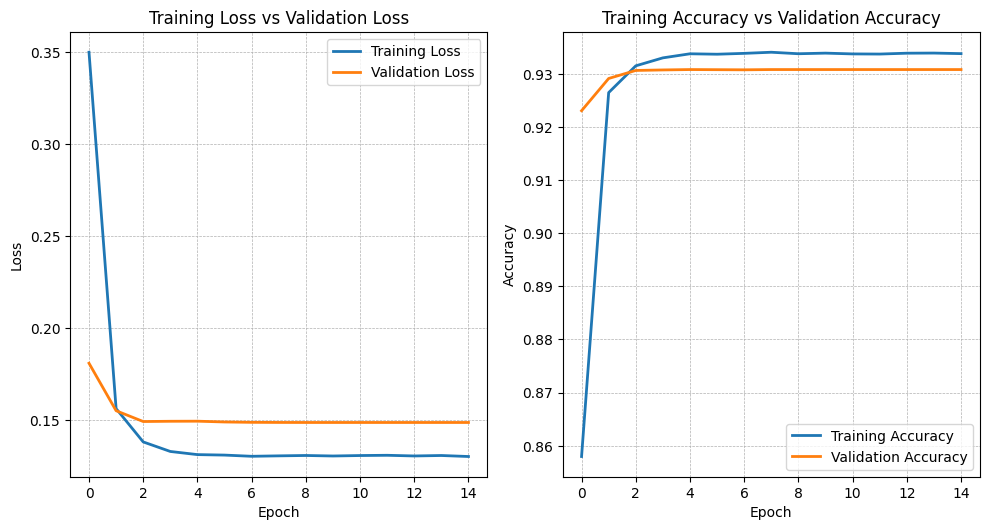

In [26]:
plot_training_history(rnn_history)

The training process shows a strong performance and stability in both the training and validation phases:  
In the early epochs, there is a clear improvement in validation loss and accuracy. This indicates that the model was learning and generalizing well in the initial phases of training.  
From epoch 3 onward, the improvements in validation loss become smaller. By epoch 8, the validation loss reaches around 0.15 and does not improve significantly afterward, fluctuating within a very narrow range.
The model seems to have reached a plateau in both training and validation loss. Accuracy also stabilizes at around 93.1% for the validation set, which suggests that the model has likely learned most of what it can from the data at this point.  
The model does not show signs of overfitting. The training and validation losses are closely aligned and validation accuracy stays consistent with training accuracy throughout the process. This indicates that early stopping and regularization strategies (like dropout or L2) are working effectively.
  
The model has converged well, with a stable performance after about 7-8 epochs. There’s minimal gain in continuing the training beyond epoch 8. The early stopping mechanism seems well-justified as further epochs did not yield significant improvement. The model has learned to a high accuracy level and further tuning may be required to break the performance plateau.

In [27]:
# Load best model from file
rnn_best_model = load_model('rnn_best_model.keras')

Precision, recall, F1-score and accuracy in the context of classification metrics:

**Precision:** Precision measures the accuracy of positive predictions. It is the ratio of true positive predictions to the sum of true positive and false positive predictions. In other words, it tells us how many of the items identified as positive are actually positive. Precision focuses on the accuracy of positive predictions.

**Recall:** Recall, also known as sensitivity or true positive rate, measures the ability of the model to find all the positive samples. It is the ratio of true positive predictions to the sum of true positive and false negative predictions. Recall tells us how many of the actual positives were captured by the model.  

**F1-Score:** The F1-score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall, especially useful when the class distribution is imbalanced. The F1-score ranges from 0 to 1, where 1 indicates perfect precision and recall.

**Accuracy:** Accuracy measures the overall correctness of the model. It is the ratio of the number of correct predictions (both true positives and true negatives) to the total number of predictions. Accuracy provides a general sense of how often the model is correct. Accuracy reflects the overall correctness of the model.

In [28]:
# Predict probabilities for each class
y_pred_probabilities_valid = rnn_best_model.predict(valid_encodings)

# Convert probabilities to class labels by taking the argmax (index of the highest probability)
y_pred_classes_valid = np.argmax(y_pred_probabilities_valid, axis=1)

# Label dictionary
label_dict = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Convert one-hot encoded test_labels back to numerical class labels
valid_labels_numerical = np.argmax(valid_labels, axis=1)

# Map numerical labels to emotional categories
y_pred_emotions_valid = [label_dict[label] for label in y_pred_classes_valid]
valid_emotions = [label_dict[label] for label in valid_labels_numerical]

# Generate classification report using emotional labels
report_valid = classification_report(valid_emotions, y_pred_emotions_valid)

print("Classification Report for Validation Data:")
print(report_valid)

1303/1303 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
Classification Report for Validation Data:
              precision    recall  f1-score   support

       anger       0.92      0.95      0.94      5761
        fear       0.89      0.90      0.89      4752
         joy       0.99      0.90      0.94     14079
        love       0.75      0.99      0.86      3549
     sadness       0.99      0.94      0.97     12044
    surprise       0.73      0.99      0.84      1496

    accuracy                           0.93     41681
   macro avg       0.88      0.95      0.91     41681
weighted avg       0.94      0.93      0.93     41681



The model achieves a high overall accuracy of 93%, which reflects a solid classification performance across the validation dataset.  
  
The model is very effective in both detecting and correctly classifying "anger".  
There's a good balance between precision and recall for "fear".  
The model almost never misclassifies other emotions as "joy". However, the recall of 0.90 shows that it occasionally misses some "joy" samples. The F1-score is 0.94, making this the strongest performing class in terms of precision.  
The model struggles a bit with the class "love", with a lower precision of 0.75 but compensates with a very high recall of 0.99, resulting in a strong F1-score of 0.86. This indicates that while the model detects most "love" samples, it sometimes incorrectly classifies other emotions as "love".  
Outstanding performance for the class "sadness", with precision of 0.99, recall of 0.94 and an F1-score of 0.97. Like with "joy", the model is highly accurate in classifying "sadness", with very few misclassifications.  
Lower precision of 0.73 but very high recall of 0.99, leading to an F1-score of 0.84 for the class "surprise". This suggests the model captures almost all "surprise" samples but frequently misclassifies other emotions as "surprise".  
  
The macro average F1-score of 0.91 indicates strong balanced performance across all emotions, despite the varying class sizes.
  
The weighted average F1-score of 0.93 is almost identical to the overall accuracy, which reflects how well the model handles the class distribution.
  
The model demonstrates a good performance, particularly in detecting "joy" and "sadness". While classes like "love" and "surprise" have lower precision, their high recall shows the model can detect these emotions well, even if it sometimes misclassifies other emotions as such. Overall, the model's results are good, particularly in handling the class imbalance, with strong F1-scores across all categories.

## Test Data

We have trained the model on the training data. Now it is time to evaluate the best model on the test data, making the test data the final and best way to assess the model's generalizability.

In [29]:
# Predict probabilities for each class
y_pred_probabilities = rnn_best_model.predict(test_encodings)

# Convert probabilities to class labels by taking the argmax (index of the highest probability)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Label dictionary
label_dict = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Convert one-hot encoded test_labels back to numerical class labels
test_labels_numerical = np.argmax(test_labels, axis=1)

# Map numerical labels to emotional categories
y_pred_emotions = [label_dict[label] for label in y_pred_classes]
test_emotions = [label_dict[label] for label in test_labels_numerical]

# Generate classification report using emotional labels
report = classification_report(test_emotions, y_pred_emotions)

print("Classification Report for Test Data:")
print(report)

1303/1303 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
Classification Report for Test Data:
              precision    recall  f1-score   support

       anger       0.92      0.95      0.93      5680
        fear       0.90      0.90      0.90      4842
         joy       0.99      0.90      0.94     14085
        love       0.74      0.99      0.85      3380
     sadness       0.99      0.95      0.97     12157
    surprise       0.72      0.99      0.83      1537

    accuracy                           0.93     41681
   macro avg       0.88      0.95      0.90     41681
weighted avg       0.94      0.93      0.93     41681



The model’s performance on the test data is highly consistent with the validation results, indicating strong generalization and reliability across both sets, particularly in detecting "joy" and "sadness". Lower precision for "love" and "surprise" remains an area for improvement, but overall, the model performs robustly.  
  
The model generalizes well and is ready for some custom sentences.

In [30]:
# Function to predict emotion
def predict_emotion(custom_sentence, bpe_tokenizer, max_length, model, label_dict):
    # Preprocess the custom sentence
    preprocessed_sentence = preprocess_text(custom_sentence)
    
    # Encode the preprocessed sentence
    encoded_sentence = bpe_encode([preprocessed_sentence], bpe_tokenizer, max_length)
    
    # Predict the class probabilities
    pred_probabilities = rnn_model.predict(encoded_sentence)
    
    # Convert probabilities to class label
    pred_class = np.argmax(pred_probabilities, axis=1)[0]
    
    # Map the class label to emotion
    pred_emotion = label_dict[pred_class]
    
    return pred_emotion

In [31]:
custom_sentence_1 = "I wouldn't say that I wasn't happy."
predicted_emotion = predict_emotion(custom_sentence_1, bpe_tokenizer, max_length, rnn_best_model, label_dict)

print(f"The predicted emotion for the sentence '{custom_sentence_1}' is: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
The predicted emotion for the sentence 'I wouldn't say that I wasn't happy.' is: joy


The model seems to understand double negation, which could be due to the preprocessing of the texts, specifically the use of Byte Pair Encoding (BPE). BPE might break down words in a way that allows the model to capture nuanced patterns like double negation more effectively during tokenization.

In [32]:
custom_sentence_2 = "I feel really good, but the bad weather annoys me a lot."
predicted_emotion = predict_emotion(custom_sentence_2, bpe_tokenizer, max_length, rnn_best_model, label_dict)

print(f"The predicted emotion for the sentence '{custom_sentence_2}' is: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The predicted emotion for the sentence 'I feel really good, but the bad weather annoys me a lot.' is: joy


This sentence expresses mixed emotions ("joy" and "anger"), making it a good test for the model that needs to classify only one dominant emotion. Which emotion is stronger?

In [33]:
custom_sentence_3 = "I feel both happy and sad at the same time."
predicted_emotion = predict_emotion(custom_sentence_3, bpe_tokenizer, max_length, rnn_best_model, label_dict)

print(f"The predicted emotion for the sentence '{custom_sentence_3}' is: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The predicted emotion for the sentence 'I feel both happy and sad at the same time.' is: joy


The two most commonly represented emotions are "joy" and "sadness". With this custom sentence, the model now has to decide between one of these two emotions.  

The model predicted joy. This choice reflects the strong performance of the model on the joy class in the test set, where it achieved an outstanding precision of 0.99 and a recall of 0.90. High precision means that when the model predicts joy, it is almost always correct, though the slightly lower recall shows that it occasionally misses true joy examples. In this ambiguous case, where both joy and sadness are plausible, the model’s preference for joy fits well with its tendency to make very reliable joy predictions.  
On the other hand, sadness also had excellent results in the test evaluation, with nearly perfect precision (0.99) and very high recall (0.95). This indicates that sadness is also a class the model recognizes with great accuracy. The fact that the model favored joy in this example could be influenced by the dataset distribution, where joy is the largest class. Combined with its extremely high precision, this likely encouraged the model to assign the label joy when faced with a mixed-emotion input.